In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Get:2 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1227 B]   
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1190 kB]
Get:4 https://packages.cloud.google.com/apt cloud-sdk InRelease [1618 B]       
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:7 https://packages.cloud.google.com/apt google-fast-socket InRelease [1071 B]0m
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]        
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1225 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [53.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/univer

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/04 20:59:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [3]:
train_csv = "/kaggle/input/eece5645-project/ISIC_2019_Training_GroundTruth.csv"
image_folder = "/kaggle/input/eece5645-project/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

In [4]:
rdd = spark.sparkContext.textFile(train_csv).map(lambda x: x.split(","))
rdd.take(5)

[['image', 'MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'],
 ['ISIC_0000000',
  '0.0',
  '1.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0'],
 ['ISIC_0000001',
  '0.0',
  '1.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0'],
 ['ISIC_0000002',
  '1.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0'],
 ['ISIC_0000003',
  '0.0',
  '1.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0',
  '0.0']]

In [5]:
classes = rdd.map(lambda x:x[1:-1]).first()
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
class_to_idx

{'MEL': 0, 'NV': 1, 'BCC': 2, 'AK': 3, 'BKL': 4, 'DF': 5, 'VASC': 6, 'SCC': 7}

In [6]:
header = rdd.first()
rdd = rdd.filter(lambda row: row!=header)
labels = rdd.map(lambda row: [float(num) for num in row[1:-1]])
len(labels.take(1)[0])

8

In [7]:
rdd = rdd.map(lambda x: (os.path.join(image_folder, f"{x[0]}.jpg" ) ,[float(num) for num in x[1:-1]] ))
rdd.take(5)

[('/kaggle/input/eece5645-project/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000000.jpg',
  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('/kaggle/input/eece5645-project/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000001.jpg',
  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('/kaggle/input/eece5645-project/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000002.jpg',
  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('/kaggle/input/eece5645-project/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000003.jpg',
  [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 ('/kaggle/input/eece5645-project/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000004.jpg',
  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])]

In [8]:
image_paths = rdd.map(lambda x:x[0])
image_paths.count()

25331

In [9]:
class_counts = labels.map(lambda x: x.index(max(x))).countByValue()
class_counts

defaultdict(int,
            {1: 12875,
             0: 4522,
             4: 2624,
             5: 239,
             7: 628,
             2: 3323,
             6: 253,
             3: 867})

In [10]:
classes

['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


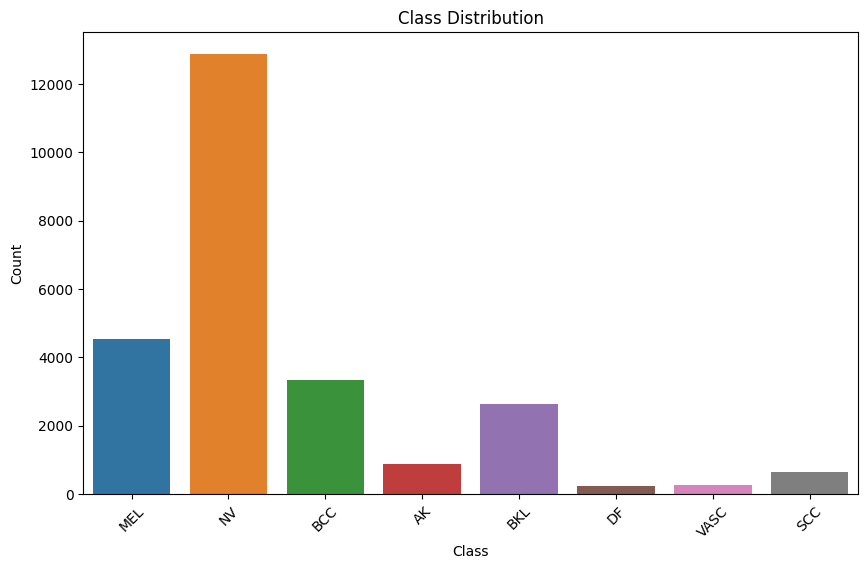

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=[class_counts[i] for i in range(len(classes))])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Split data in PySpark
train_data_rdd, test_data_rdd = rdd.randomSplit([0.8, 0.2], seed=42)

# Convert back to separate RDDs if needed
train_images = train_data_rdd.map(lambda x: x[0]).repartition(100).collect()
train_labels = train_data_rdd.map(lambda x: x[1]).repartition(100).collect()
test_images = test_data_rdd.map(lambda x: x[0]).repartition(100).collect()
test_labels = test_data_rdd.map(lambda x: x[1]).repartition(100).collect()

In [13]:
# Preprocessing functions
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [260, 260])  # Resize without 'nearest' mode
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def load_and_preprocess_from_path_labels(path, label):
    return load_and_preprocess_image(path), label

In [14]:
import tensorflow as tf

In [15]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE)\
                   .map(data_augment, num_parallel_calls=tf.data.AUTOTUNE)\
                   .shuffle(2048).batch(32).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.map(load_and_preprocess_from_path_labels, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
# Define learning rate schedule
LR_START = 0.00001
LR_MAX = 0.00005 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = 0.8
EPOCHS = 15

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [17]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(include_top=False, input_shape=(260, 260, 3), pooling='avg')
base_output = base_model.output
classifier = tf.keras.layers.Dense(len(classes), activation='softmax')(base_output)
model = tf.keras.Model(inputs=base_model.input, outputs=classifier)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [18]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [19]:
import time 
start_time = time.time()
# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[lr_callback],
)
end_time = time.time()
print(f"Time taken: {end_time - start_time:2f} seconds")


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/15


I0000 00:00:1733346227.150720     919 service.cc:145] XLA service 0x79d4740038a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733346227.150784     919 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733346254.017744     919 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1733346254.062108     919 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


634/634 ━━━━━━━━━━━━━━━━━━━━ 251s 294ms/step - accuracy: 0.5660 - loss: 1.2222 - val_accuracy: 0.2382 - val_loss: 1.9794 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 162s 246ms/step - accuracy: 0.7432 - loss: 0.7238 - val_accuracy: 0.7403 - val_loss: 0.7354 - learning_rate: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 3.0000000000000004e-05.
Epoch 3/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 161s 245ms/step - accuracy: 0.8199 - loss: 0.5074 - val_accuracy: 0.6897 - val_loss: 0.9462 - learning_rate: 3.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 4e-05.
Epoch 4/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 161s 245ms/step - accuracy: 0.8745 - loss: 0.3590 - val_accuracy: 0.7590 - val_loss: 0.7181 - learning_rate: 4.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 5e-05.
Epoch 5/15
634/634 ━━━━━━━━━━━━━━━━━━━━ 161s 245ms/step - accuracy: 0.9022 - loss: 0.2749 - val_ac

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 266, 266,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 130, 130,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 130, 130,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 130, 130,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 132, 132,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 65, 65,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 65, 65,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 65, 65,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 65, 65,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 65, 65,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 65, 65,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 65, 65,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 65, 65,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 65, 65,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 65, 65,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 65, 65,    │      1,024 │ conv2_block1_3_c

 Total params: 70,706,074 (269.72 MB)

 Trainable params: 23,550,984 (89.84 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,101,970 (179.68 MB)

In [21]:
# Evaluate model performance
y_true = np.argmax(test_labels, axis=1)
y_pred = np.argmax(model.predict(test_ds), axis=1)

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step


In [22]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8214497333596682
Precision: 0.7706903484806297
Recall: 0.6887330840885058
Confusion Matrix:
 [[ 638  205   12   19   44    0    0    5]
 [  71 2412    9    3   46    0    3    2]
 [  26   66  502   27   29    2    0   23]
 [   3    6   12  106   25    0    0    9]
 [  24  106    9   21  382    1    0    3]
 [   0   14    3    4    0   23    0    4]
 [   3    5    2    0    0    0   35    0]
 [   9    7   11   17   13    1    0   61]]
